In [1]:
import pandas as pd
import numpy as np


In [2]:
from metrics_f1 import calc_f1_score

In [19]:
!pip install pyarrow

# Препроцессинг данных

In [3]:
path_train = r"./train"

In [4]:
# данные по дислокации
dislok = pd.read_parquet(path_train + '/dislok_wagons.parquet').convert_dtypes()
# данные по текущим ремонтам
pr_rem = pd.read_parquet(path_train + '/pr_rems.parquet').convert_dtypes()
# список вагонов с остаточным пробегом на момент прогноза
wag_prob = pd.read_parquet(path_train + '/wagons_probeg_ownersip.parquet').convert_dtypes()
 # параметры вагона
wag_param = pd.read_parquet(path_train + '/wag_params.parquet').convert_dtypes()
wag_param = wag_param.drop_duplicates(subset='wagnum', keep='last')
# таргет по прогноза выбытия вагонов в ПР на месяц и на 10 дней
target = pd.read_csv(path_train +'/target/y_train.csv').convert_dtypes()
 # текущие ремонты вагонов
tr_rem = pd.read_parquet(path_train + '/tr_rems.parquet').convert_dtypes()

In [5]:
month_to_predict = pd.to_datetime('2022-12-01')

## Подготовка датафрейма дислокации
Здесь мы хотим преобразовать временные данные по Дислокации в данные по одному ключу-номеру вагона, для этого мы набираем акутальную информацию (с последнего ремонта капитального или деповского) :
- Весь пройденный путь
- Весь пройденный путь (груженный)
- Время с последнего ремонта
- Остаточный проблег

In [6]:
dislok.head()

,plan_date,wagnum,date_kap,date_dep,kod_vrab,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob,isload,fr_id,last_fr_id,distance
0,2022-08-01,1071,NaT,2020-02-16,0,2023-02-16,42,22,42,11470,42,36899,0,5032,1413,-1
1,2022-08-02,1071,NaT,2020-02-16,0,2023-02-16,42,11663,0,11470,42,36899,1,1204,1204,998
2,2022-08-03,1071,NaT,2020-02-16,0,2023-02-16,42,11663,0,11470,42,36711,1,1204,1204,989
3,2022-08-04,1071,NaT,2020-02-16,0,2023-02-16,42,11663,0,11470,42,36711,1,1204,1204,939
4,2022-08-05,1071,NaT,2020-02-16,0,2023-02-16,42,11663,0,11470,42,36711,1,1204,1204,963


In [7]:
date_min = min( dislok.plan_date.min(), dislok.date_dep.min(), dislok.date_pl_rem.min() )
date_min = np.datetime64(date_min).astype('datetime64[D]')
date_min # время относительно которого будет считаться дельта для дат, нужно для перевода в численный формат

numpy.datetime64('2013-07-20')

In [8]:
from IPython.display import clear_output

dislok_prep = dislok[['wagnum', 'plan_date']][dislok.plan_date < month_to_predict].groupby('wagnum', as_index=False).max()

dislok_prep['distance_since_kap'] = 0
dislok_prep['distance_since_dep'] = 0
dislok_prep['last_kap'] = 0
dislok_prep['last_dep'] = 0
dislok_prep['date_pl_rem'] = 0
dislok_prep['ost_probeg'] = 0

dislok_prep['distance_since_kap_loaded'] = 0
dislok_prep['distance_since_dep_loaded'] = 0

for wagnum in dislok_prep.index:
    print(f'runing {wagnum} out of {len(dislok_prep.index)}')
    tmp_df = dislok.loc[(dislok.wagnum == wagnum) \
                        & (dislok.plan_date < month_to_predict)
                        & (dislok.distance >= 0)]
    
    last_kap = tmp_df.date_kap.max()
    last_dep = tmp_df.date_dep.max()
    
    dislok_prep.at[wagnum, 'date_pl_rem'] = (tmp_df.date_pl_rem.max().to_numpy().astype('datetime64[D]') - date_min).astype('timedelta64[D]').astype('float')
    
    if pd.isnull(last_kap):
        last_kap = tmp_df.plan_date.min()
    if pd.isnull(last_dep):
        last_dep = tmp_df.plan_date.min()
    
    dislok_prep.at[wagnum, 'distance_since_kap'] = tmp_df.loc[tmp_df.plan_date >= last_kap].distance.sum()
    dislok_prep.at[wagnum, 'distance_since_dep'] = tmp_df.loc[tmp_df.plan_date >= last_dep].distance.sum()
    dislok_prep.at[wagnum, 'distance_since_kap_loaded'] = tmp_df.loc[(tmp_df.plan_date >= last_kap) \
                                                                    & (tmp_df.isload == 1)].distance.sum()
    dislok_prep.at[wagnum, 'distance_since_dep_loaded'] = tmp_df.loc[(tmp_df.plan_date >= last_dep) \
                                                                    & (tmp_df.isload == 1)].distance.sum()
    dislok_prep.at[wagnum, 'last_kap'] = (last_kap.to_numpy().astype('datetime64[D]') - date_min).astype('timedelta64[D]').astype('float')
    dislok_prep.at[wagnum, 'last_dep'] = (last_dep.to_numpy().astype('datetime64[D]') - date_min).astype('timedelta64[D]').astype('float')
    tmp_df = tmp_df.loc[tmp_df.ost_prob.apply(lambda x: type(x) == int)]
    if len(tmp_df) > 0:
        dislok_prep.at[wagnum, 'ost_probeg'] = tmp_df.loc[tmp_df.plan_date > min(last_kap, last_dep)].ost_prob.min()
    else:
        dislok_prep.at[wagnum, 'ost_probeg'] = 1e8
    clear_output()
dislok_prep.head()

,wagnum,plan_date,distance_since_kap,distance_since_dep,last_kap,last_dep,date_pl_rem,ost_probeg,distance_since_kap_loaded,distance_since_dep_loaded
0,0,2022-11-30,73178,73178,16,2482,3577,65850,1347,1347
1,1,2022-11-30,152623,152623,2993,1911,3999,98109,43000,43000
2,2,2022-11-30,147132,147132,-1602,3000,4048,59309,49612,49612
3,3,2022-11-30,103608,103608,-1313,2987,3908,67032,75400,75400
4,4,2022-11-30,5094,5094,-1307,3053,4149,108915,4866,4866


## Подготовка таргет-данных

In [9]:
target.month = pd.to_datetime(target.month)
target = target[target.month == month_to_predict][['wagnum','target_month','target_day']]

In [10]:
wagons = np.intersect1d(target.wagnum.to_numpy(), dislok_prep.wagnum.to_numpy())

In [11]:
dislok_slice = dislok_prep.loc[dislok_prep.wagnum.isin(wagons)].sort_values(by=['wagnum'])
target_slice = target.loc[target.wagnum.isin(wagons)].sort_values(by=['wagnum'])

In [12]:
target_slice.head()

,wagnum,target_month,target_day
200200,0,0,0
200507,1,0,0
197931,2,0,0
196022,3,0,0
201174,4,0,0


In [13]:
dislok_slice.head()

,wagnum,plan_date,distance_since_kap,distance_since_dep,last_kap,last_dep,date_pl_rem,ost_probeg,distance_since_kap_loaded,distance_since_dep_loaded
0,0,2022-11-30,73178,73178,16,2482,3577,65850,1347,1347
1,1,2022-11-30,152623,152623,2993,1911,3999,98109,43000,43000
2,2,2022-11-30,147132,147132,-1602,3000,4048,59309,49612,49612
3,3,2022-11-30,103608,103608,-1313,2987,3908,67032,75400,75400
4,4,2022-11-30,5094,5094,-1307,3053,4149,108915,4866,4866


## Рабочий датафрейм

In [14]:
df = dislok_slice.join(wag_param[['wagnum','model', 'gruz', 'norma_km', 'tara', 'zavod_build', 'ownertype', 'cnsi_probeg_kr']].set_index('wagnum'), on='wagnum', how='left') # Рабочий датафрейм

In [15]:
# переводим в оставшийся пробег до нормы

df['distance_since_kap'] = df['norma_km'] - df['distance_since_kap']
df['distance_since_dep'] = df['norma_km'] - df['distance_since_dep']
df['distance_since_kap_loaded'] = df['norma_km'] - df['distance_since_kap_loaded']
df['distance_since_dep_loaded'] = df['norma_km'] - df['distance_since_dep_loaded']

In [16]:
df = df.dropna()

## Скореллированность признаков в датафрейме

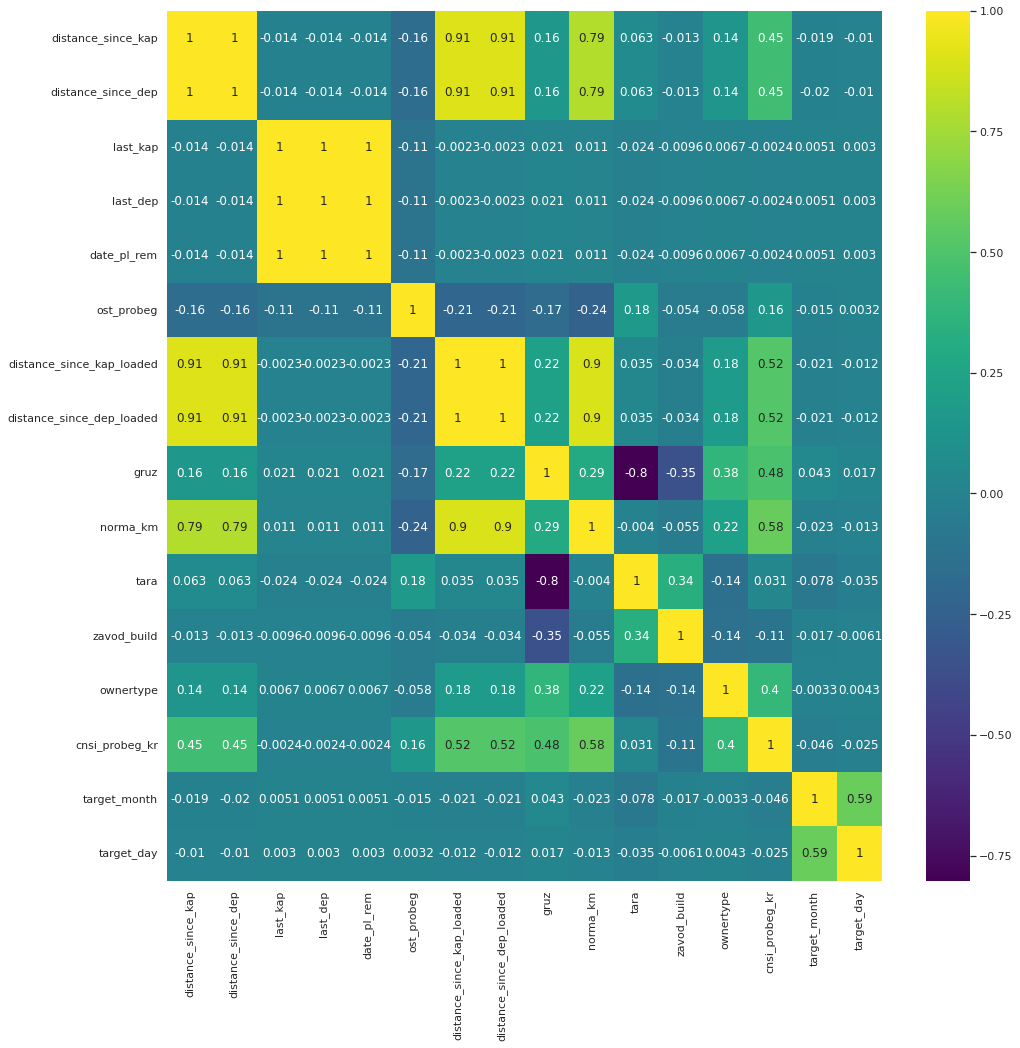

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

df['target_month'] = 0
df['target_day'] = 0
df.target_month = target_slice.target_month.to_numpy().astype('int')
df.target_day = target_slice.target_day.to_numpy().astype('int')

sns.set_theme(style="white")
corr = df.dropna().corr()
fig, ax = plt.subplots(figsize=(16, 16))
ax = sns.heatmap(corr, annot=True, cmap="viridis")

## Что можно убрать
- Тара (скореллирована с грузом)
- Норма в км (уже тоже не нужна)

In [18]:
df = df.drop(['tara', 'norma_km'], axis=1)

In [19]:
df['plan_date'] = ((df['plan_date'].to_numpy().astype('datetime64[D]') - date_min).astype('timedelta64[D]').astype('float'))

# Catboost implementation

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33977 entries, 0 to 33976
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wagnum                     33977 non-null  object 
 1   plan_date                  33977 non-null  float64
 2   distance_since_kap         33977 non-null  Int64  
 3   distance_since_dep         33977 non-null  Int64  
 4   last_kap                   33977 non-null  int64  
 5   last_dep                   33977 non-null  int64  
 6   date_pl_rem                33977 non-null  int64  
 7   ost_probeg                 33977 non-null  int64  
 8   distance_since_kap_loaded  33977 non-null  Int64  
 9   distance_since_dep_loaded  33977 non-null  Int64  
 10  model                      33977 non-null  string 
 11  gruz                       33977 non-null  Int64  
 12  zavod_build                33977 non-null  Int64  
 13  ownertype                  33977 non-null  Int

In [38]:
!pip install catboost

## Модель для предсказания месяца

In [241]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split

y = df[['target_month', 'target_day']].to_numpy()
X = df.drop(['wagnum', 'plan_date', 'zavod_build', 'cnsi_probeg_kr', 'target_month', 'target_day'], axis=1).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # трейн-тест сплит по вагонам

In [240]:
# считаем пропорцию единиц-таргетов чтобы взвесить лосс-функцию в модели
# это надо чтобы обучаться по несбалансированной выборке
prop = np.sum(y_train[:, 0]) / len(y_train[:, 0])
w_train = 1 / prop * y_train[:, 0] + 1. * (y_train[:, 0] == 0)
print(prop)

prop = np.sum(y_test[:, 0]) / len(y_test[:, 0])
w_test = 1 / prop * y_test[:, 0] + 1. * (y_test[:, 0] == 0)
print(prop)

0.04749641293550642
0.04311359623307828


In [242]:
df.drop(['wagnum', 'plan_date', 'zavod_build', 'cnsi_probeg_kr'], axis = 1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33977 entries, 0 to 33976
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   distance_since_kap         33977 non-null  int64 
 1   distance_since_dep         33977 non-null  int64 
 2   last_kap                   33977 non-null  int64 
 3   last_dep                   33977 non-null  int64 
 4   date_pl_rem                33977 non-null  int64 
 5   ost_probeg                 33977 non-null  int64 
 6   distance_since_kap_loaded  33977 non-null  int64 
 7   distance_since_dep_loaded  33977 non-null  int64 
 8   model                      33977 non-null  object
 9   gruz                       33977 non-null  int64 
 10  ownertype                  33977 non-null  int64 
 11  target_month               33977 non-null  int64 
 12  target_day                 33977 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 3.4+ MB


In [205]:
# запись данных для обучения
df.to_csv('train_df.csv')

In [235]:
# чтение данных для обученя
df = pd.read_csv('train_df.csv')

In [243]:
df

,wagnum,plan_date,distance_since_kap,distance_since_dep,last_kap,last_dep,date_pl_rem,ost_probeg,distance_since_kap_loaded,distance_since_dep_loaded,model,gruz,zavod_build,ownertype,cnsi_probeg_kr,target_month,target_day
0,0,3420.0,86822,86822,16,2482,3577,65850,158653,158653,11-276,680,1,0,160,0,0
1,1,3420.0,7377,7377,2993,1911,3999,98109,117000,117000,11-066-04,680,1,0,160,0,0
2,2,3420.0,-37132,-37132,-1602,3000,4048,59309,60388,60388,Р-9494-01,680,1,0,160,0,0
3,3,3420.0,6392,6392,-1313,2987,3908,67032,34600,34600,11-066-04,680,1,0,160,0,0
4,4,3420.0,154906,154906,-1307,3053,4149,108915,155134,155134,11-217,680,23,0,160,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33972,33972,3420.0,113606,113606,-976,2448,3543,1222,150481,150481,12-532-02,700,0,0,160,0,0
33973,33973,3420.0,122560,122560,-976,2705,3800,131,145127,145127,12-532-02,700,0,0,160,0,0
33974,33974,3420.0,102236,102236,-792,2324,3420,24643,109868,109868,12-532-02,700,0,0,160,0,0
33975,33975,3420.0,36909,36909,-858,2592,3687,1358,119268,119268,12-532-02,700,0,0,160,0,0


In [244]:
# индексы категориальных фич
cat_features = [8, 10]

train_pool = Pool(X_train,
                  y_train[:, 0], 
                  cat_features=cat_features,
                  weight = w_train)

test_pool = Pool(X_test,
                 y_test[:, 0], 
                  cat_features=cat_features,
                  weight = w_test)

model = CatBoostClassifier(depth = 16, iterations= 50, task_type="GPU", loss_function='CrossEntropy', eval_metric='F1')

## Обучение модели
На каждой иттерации модель выводит значение f1-score на тесте и трейне

In [245]:
model.fit(train_pool, eval_set=test_pool)

0:	learn: 0.8913345	test: 0.8324215	best: 0.8324215 (0)	total: 2.68s	remaining: 2m 11s
1:	learn: 0.8933839	test: 0.8531706	best: 0.8531706 (1)	total: 5.09s	remaining: 2m 2s
2:	learn: 0.8887911	test: 0.8669901	best: 0.8669901 (2)	total: 5.88s	remaining: 1m 32s
3:	learn: 0.8894034	test: 0.8674057	best: 0.8674057 (3)	total: 8.55s	remaining: 1m 38s
4:	learn: 0.8900315	test: 0.8708100	best: 0.8708100 (4)	total: 10.8s	remaining: 1m 36s
5:	learn: 0.8895102	test: 0.8710487	best: 0.8710487 (5)	total: 13s	remaining: 1m 35s
6:	learn: 0.8877435	test: 0.8755706	best: 0.8755706 (6)	total: 13.6s	remaining: 1m 23s
7:	learn: 0.8893348	test: 0.8758690	best: 0.8758690 (7)	total: 16.1s	remaining: 1m 24s
8:	learn: 0.8897691	test: 0.8749849	best: 0.8758690 (7)	total: 18.8s	remaining: 1m 25s
9:	learn: 0.8897881	test: 0.8744471	best: 0.8758690 (7)	total: 21s	remaining: 1m 23s
10:	learn: 0.8894995	test: 0.8747458	best: 0.8758690 (7)	total: 23.6s	remaining: 1m 23s
11:	learn: 0.8896792	test: 0.8710487	best: 0.87

In [246]:
model.save_model('model_month')

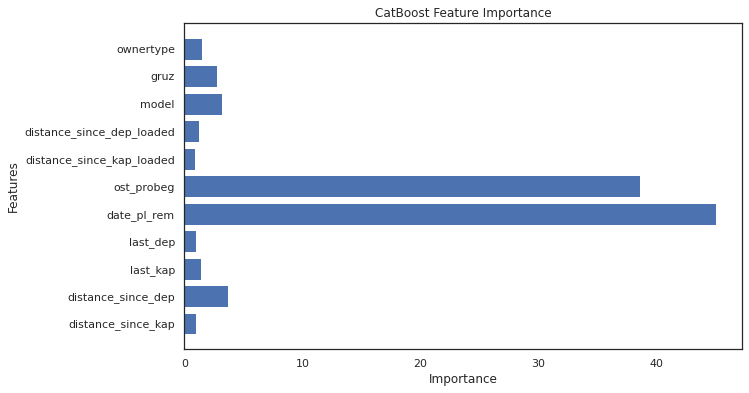

In [247]:
feature_importances = model.get_feature_importance(type='PredictionValuesChange')
plt.figure(figsize=(10, 6))
plt.barh(df.drop(['wagnum', 'plan_date', 'zavod_build', 'cnsi_probeg_kr', 'target_month', 'target_day'], axis=1).columns.to_numpy(), feature_importances)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

## Модель для предсказания дня

In [248]:
prop = np.sum(y_train[:, 1]) / len(y_train[:, 1])
w_train = 1 / prop * y_train[:, 1] + 1. * (y_train[:, 1] == 0)
print(prop)

prop = np.sum(y_test[:, 1]) / len(y_test[:, 1])
w_test = 1 / prop * y_test[:, 1] + 1. * (y_test[:, 1] == 0)
print(prop)

0.0169971671388102
0.015891701000588582


In [249]:
train_pool = Pool(X_train,
                  y_train[:, 1], 
                  cat_features=cat_features,
                  weight = w_train)

test_pool = Pool(X_test,
                 y_test[:, 1], 
                  cat_features=cat_features,
                  weight = w_test)

model_d = CatBoostClassifier(depth = 16, iterations= 50, task_type="GPU", loss_function='CrossEntropy', eval_metric='F1')

In [250]:
model_d.fit(train_pool, eval_set=test_pool)

0:	learn: 0.9023166	test: 0.7775744	best: 0.7775744 (0)	total: 2.68s	remaining: 2m 11s
1:	learn: 0.9078676	test: 0.8003221	best: 0.8003221 (1)	total: 4.9s	remaining: 1m 57s
2:	learn: 0.8975911	test: 0.8423557	best: 0.8423557 (2)	total: 5.68s	remaining: 1m 28s
3:	learn: 0.9039845	test: 0.8494464	best: 0.8494464 (3)	total: 8.21s	remaining: 1m 34s
4:	learn: 0.9035035	test: 0.8393667	best: 0.8494464 (3)	total: 10.9s	remaining: 1m 38s
5:	learn: 0.9049993	test: 0.8287960	best: 0.8494464 (3)	total: 13.6s	remaining: 1m 39s
6:	learn: 0.9063662	test: 0.8450634	best: 0.8494464 (3)	total: 16.2s	remaining: 1m 39s
7:	learn: 0.9069735	test: 0.8393667	best: 0.8494464 (3)	total: 18.6s	remaining: 1m 37s
8:	learn: 0.9079624	test: 0.8505341	best: 0.8505341 (8)	total: 21.3s	remaining: 1m 36s
9:	learn: 0.9073080	test: 0.8450634	best: 0.8505341 (8)	total: 24s	remaining: 1m 35s
10:	learn: 0.9065779	test: 0.8378045	best: 0.8505341 (8)	total: 26.7s	remaining: 1m 34s
11:	learn: 0.9075486	test: 0.8441589	best: 0.

In [251]:
model_d.save_model('model_days')

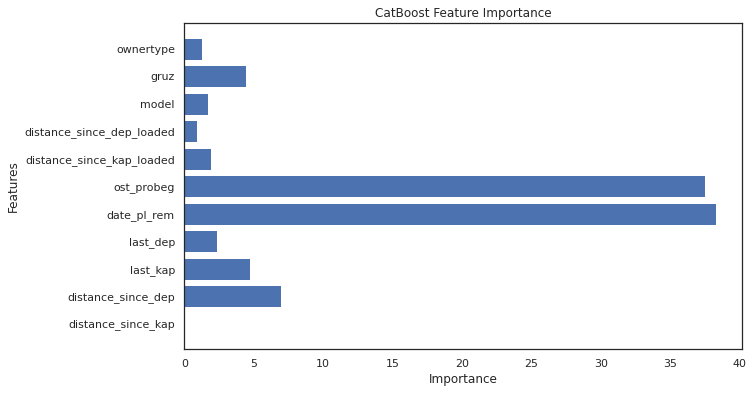

In [252]:
feature_importances = model_d.get_feature_importance(type='PredictionValuesChange')
plt.figure(figsize=(10, 6))
plt.barh(df.drop(['wagnum', 'plan_date', 'zavod_build', 'cnsi_probeg_kr', 'target_month', 'target_day'], axis=1).columns.to_numpy(), feature_importances)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Test prediction

In [50]:
## Чтение данных

In [94]:
path_test = './test'

# данные по дислокации
dislok_pred = pd.read_parquet(path_train + '/dislok_wagons.parquet').convert_dtypes() # предыдущие данные по дислокации
dislok = pd.read_parquet(path_test + '/dislok_wagons.parquet').convert_dtypes()

dislok = pd.concat([dislok, dislok_pred])

# данные по текущим ремонтам
pr_rem = pd.read_parquet(path_test + '/pr_rems.parquet').convert_dtypes()
# список вагонов с остаточным пробегом на момент прогноза
wag_prob = pd.read_parquet(path_test + '/wagons_probeg_ownersip.parquet').convert_dtypes()
 # параметры вагона
wag_param = pd.read_parquet(path_test + '/wag_params.parquet').convert_dtypes()
wag_param = wag_param.drop_duplicates(subset='wagnum', keep='last')
# таргет по прогноза выбытия вагонов в ПР на месяц и на 10 дней
target = pd.read_csv('./target' +'/y_predict_submit_example.csv').convert_dtypes()
 # текущие ремонты вагонов
tr_rem = pd.read_parquet(path_test + '/tr_rems.parquet').convert_dtypes()

In [95]:
month_to_predict = pd.to_datetime('2023-03-01') # предсказываем на март

In [96]:
dislok.head()

,plan_date,wagnum,date_kap,date_dep,kod_vrab,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob,isload,fr_id,last_fr_id,distance
0,2023-02-01,56,2018-11-30,2021-11-10,0,2024-11-10,40,498,3,16008,40,110121,1,1671,1671,-1
1,2023-02-02,56,2018-11-30,2021-11-10,0,2024-11-10,40,498,3,16008,40,109917,1,1671,1671,940
2,2023-02-03,56,2018-11-30,2021-11-10,0,2024-11-10,38,498,3,16008,40,109058,1,1671,1671,934
3,2023-02-04,56,2018-11-30,2021-11-10,0,2024-11-10,38,498,3,16008,40,108354,1,1671,1671,933
4,2023-02-05,56,2018-11-30,2021-11-10,0,2024-11-10,36,498,3,16008,40,107469,1,1671,1671,937


In [97]:
from IPython.display import clear_output

dislok_prep = dislok[['wagnum', 'plan_date']][dislok.plan_date < month_to_predict].groupby('wagnum', as_index=False).max()

dislok_prep['distance_since_kap'] = 0
dislok_prep['distance_since_dep'] = 0
dislok_prep['last_kap'] = 0
dislok_prep['last_dep'] = 0
dislok_prep['date_pl_rem'] = 0
dislok_prep['ost_probeg'] = 0

dislok_prep['distance_since_kap_loaded'] = 0
dislok_prep['distance_since_dep_loaded'] = 0

for wagnum in dislok_prep.index:
    print(f'runing {wagnum} out of {len(dislok_prep.index)}')
    tmp_df = dislok.loc[(dislok.wagnum == wagnum) \
                        & (dislok.plan_date < month_to_predict)
                        & (dislok.distance >= 0)]
    
    last_kap = tmp_df.date_kap.max()
    last_dep = tmp_df.date_dep.max()
    
    dislok_prep.at[wagnum, 'date_pl_rem'] = (tmp_df.date_pl_rem.max().to_numpy().astype('datetime64[D]') - date_min).astype('timedelta64[D]').astype('float')
    
    if pd.isnull(last_kap):
        last_kap = tmp_df.plan_date.min()
    if pd.isnull(last_dep):
        last_dep = tmp_df.plan_date.min()
    
    dislok_prep.at[wagnum, 'distance_since_kap'] = tmp_df.loc[tmp_df.plan_date >= last_kap].distance.sum()
    dislok_prep.at[wagnum, 'distance_since_dep'] = tmp_df.loc[tmp_df.plan_date >= last_dep].distance.sum()
    dislok_prep.at[wagnum, 'distance_since_kap_loaded'] = tmp_df.loc[(tmp_df.plan_date >= last_kap) \
                                                                    & (tmp_df.isload == 1)].distance.sum()
    dislok_prep.at[wagnum, 'distance_since_dep_loaded'] = tmp_df.loc[(tmp_df.plan_date >= last_dep) \
                                                                    & (tmp_df.isload == 1)].distance.sum()
    dislok_prep.at[wagnum, 'last_kap'] = (last_kap.to_numpy().astype('datetime64[D]') - date_min).astype('timedelta64[D]').astype('float')
    dislok_prep.at[wagnum, 'last_dep'] = (last_dep.to_numpy().astype('datetime64[D]') - date_min).astype('timedelta64[D]').astype('float')
    tmp_df = tmp_df.loc[tmp_df.ost_prob.apply(lambda x: type(x) == int)]
    if len(tmp_df) > 0:
        dislok_prep.at[wagnum, 'ost_probeg'] = tmp_df.loc[tmp_df.plan_date > min(last_kap, last_dep)].ost_prob.min()
    else:
        dislok_prep.at[wagnum, 'ost_probeg'] = 1e8
    clear_output()
dislok_prep.head()

,wagnum,plan_date,distance_since_kap,distance_since_dep,last_kap,last_dep,date_pl_rem,ost_probeg,distance_since_kap_loaded,distance_since_dep_loaded
0,0,2023-02-28,123945,123945,16,2482,3577,45806,34836,34836
1,1,2023-02-28,211516,211516,2993,1911,3999,93045,46369,46369
2,2,2023-02-28,176625,176625,-1602,3000,4048,52247,59359,59359
3,3,2023-02-28,136568,136568,-1313,2987,3908,52596,76165,76165
4,4,2023-02-28,34305,34305,-1307,3053,4149,87594,8705,8705


In [98]:
wagons = np.intersect1d(target.wagnum.to_numpy(), dislok_prep.wagnum.to_numpy())

In [99]:
dislok_slice = dislok_prep.loc[dislok_prep.wagnum.isin(wagons)].sort_values(by=['wagnum'])
target_slice = target.loc[target.wagnum.isin(wagons)].sort_values(by=['wagnum'])

In [221]:
df = dislok_slice.join(wag_param[['wagnum','model', 'gruz', 'zavod_build', 'ownertype', 'cnsi_probeg_kr', 'norma_km']].set_index('wagnum'), on='wagnum', how='left')

In [223]:
df['distance_since_kap'] = df['norma_km'] - df['distance_since_kap']
df['distance_since_dep'] = df['norma_km'] - df['distance_since_dep']
df['distance_since_kap_loaded'] = df['norma_km'] - df['distance_since_kap_loaded']
df['distance_since_dep_loaded'] = df['norma_km'] - df['distance_since_dep_loaded']

df = df.drop(['norma_km'], axis = 1)

In [224]:
df

,wagnum,plan_date,distance_since_kap,distance_since_dep,last_kap,last_dep,date_pl_rem,ost_probeg,distance_since_kap_loaded,distance_since_dep_loaded,model,gruz,zavod_build,ownertype,cnsi_probeg_kr
0,0,2023-02-28,36055,36055,16,2482,3577,45806,125164,125164,11-276,680,1,0,160
1,1,2023-02-28,-51516,-51516,2993,1911,3999,93045,113631,113631,11-066-04,680,1,0,160
2,2,2023-02-28,-66625,-66625,-1602,3000,4048,52247,50641,50641,Р-9494-01,680,1,0,160
3,3,2023-02-28,-26568,-26568,-1313,2987,3908,52596,33835,33835,11-066-04,680,1,0,160
4,4,2023-02-28,125695,125695,-1307,3053,4149,87594,151295,151295,11-217,680,23,0,160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33972,33972,2023-02-28,84389,84389,-976,2448,3543,1222,128322,128322,12-532-02,700,0,0,160
33973,33973,2023-02-28,74804,74804,-976,2705,3800,131,123818,123818,12-532-02,700,0,0,160
33974,33974,2023-02-28,42416,42416,-792,2324,3420,24643,70401,70401,12-532-02,700,0,0,160
33975,33975,2023-02-28,13726,13726,-858,2592,3687,1358,99205,99205,12-532-02,700,0,0,160


In [226]:
X = df.drop(['wagnum', 'plan_date', 'zavod_build', 'cnsi_probeg_kr'], axis=1).to_numpy() # Матрица для предсказания
X.shape

(33707, 11)

In [227]:
y_pred1 = model.predict(X) # предсказание месяца
y_pred2 = model_d.predict(X) # предсказание дня

In [228]:
df.reset_index(inplace=True)

In [229]:
df

,index,wagnum,plan_date,distance_since_kap,distance_since_dep,last_kap,last_dep,date_pl_rem,ost_probeg,distance_since_kap_loaded,distance_since_dep_loaded,model,gruz,zavod_build,ownertype,cnsi_probeg_kr
0,0,0,2023-02-28,36055,36055,16,2482,3577,45806,125164,125164,11-276,680,1,0,160
1,1,1,2023-02-28,-51516,-51516,2993,1911,3999,93045,113631,113631,11-066-04,680,1,0,160
2,2,2,2023-02-28,-66625,-66625,-1602,3000,4048,52247,50641,50641,Р-9494-01,680,1,0,160
3,3,3,2023-02-28,-26568,-26568,-1313,2987,3908,52596,33835,33835,11-066-04,680,1,0,160
4,4,4,2023-02-28,125695,125695,-1307,3053,4149,87594,151295,151295,11-217,680,23,0,160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33702,33972,33972,2023-02-28,84389,84389,-976,2448,3543,1222,128322,128322,12-532-02,700,0,0,160
33703,33973,33973,2023-02-28,74804,74804,-976,2705,3800,131,123818,123818,12-532-02,700,0,0,160
33704,33974,33974,2023-02-28,42416,42416,-792,2324,3420,24643,70401,70401,12-532-02,700,0,0,160
33705,33975,33975,2023-02-28,13726,13726,-858,2592,3687,1358,99205,99205,12-532-02,700,0,0,160


In [230]:
from copy import deepcopy

target_pred = deepcopy(target)

# записываем предсказание по вагонам
for i, row in df.iterrows():
    wag = row['wagnum']
    
    target_pred.at[target_pred.wagnum == wag, 'target_month'] = max(y_pred1[i], y_pred2[i])
    target_pred.at[target_pred.wagnum == wag, 'target_day'] = y_pred2[i]

In [231]:
len(target_pred)

33707

In [232]:
target_pred.sample(10)

,wagnum,month,target_month,target_day
11228,28985,2023-03-01,1,1
24691,33936,2023-03-01,1,1
13035,22701,2023-03-01,1,1
69,5768,2023-03-01,0,0
7799,33706,2023-03-01,0,0
20410,25656,2023-03-01,1,1
2763,11001,2023-03-01,0,0
4181,19767,2023-03-01,0,0
14986,6211,2023-03-01,0,0
33104,2494,2023-03-01,0,0


In [233]:
target_pred.to_csv('y_test_pred.csv') # записываем предсказание